In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [6]:
image_dir = "/kaggle/input/sample/Sample Images"

In [7]:
images = []
for filename in os.listdir(image_dir):
    img = cv2.imread(os.path.join(image_dir, filename))
    if img is not None:
        images.append(img)

print("Number of images:", len(images))

Number of images: 203


Image: 1


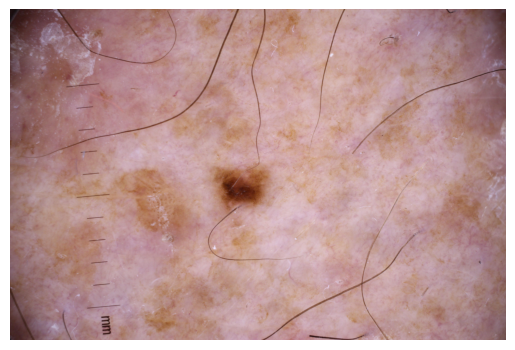

Image: 2


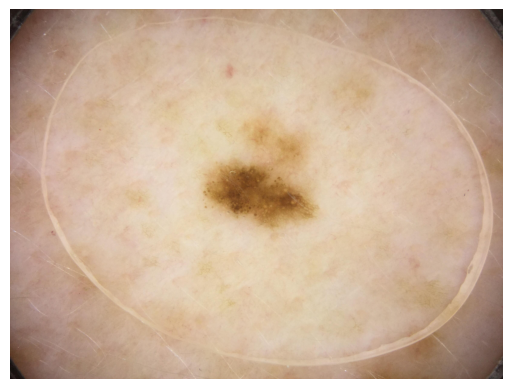

Image: 3


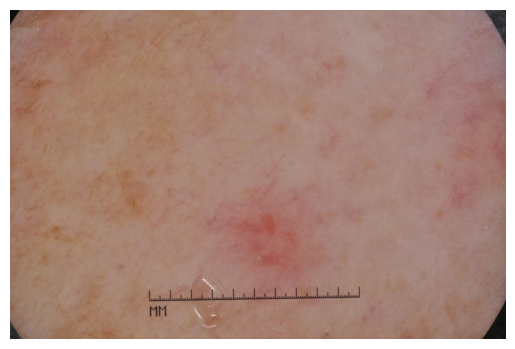

Image: 4


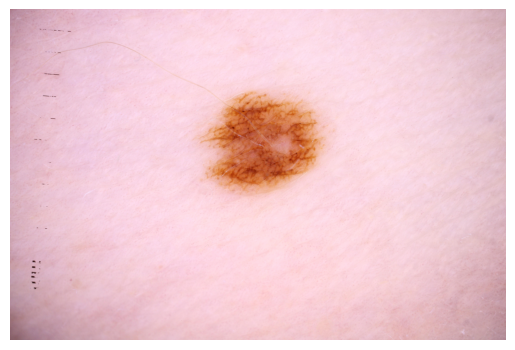

Image: 5


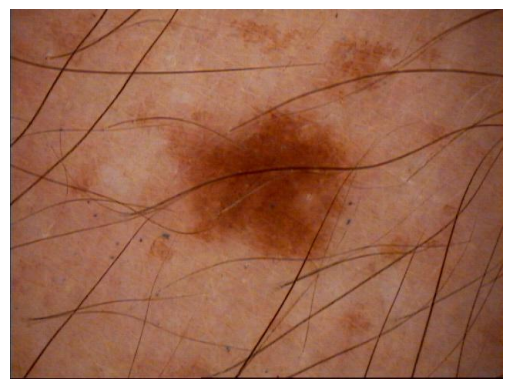

Image: 6


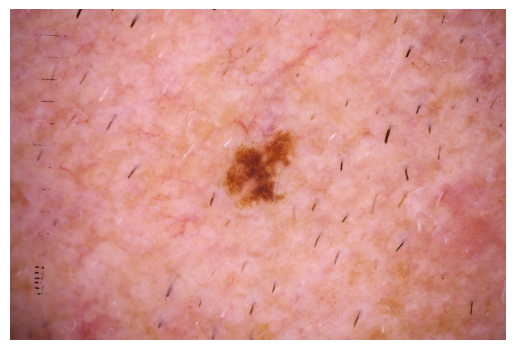

Image: 7


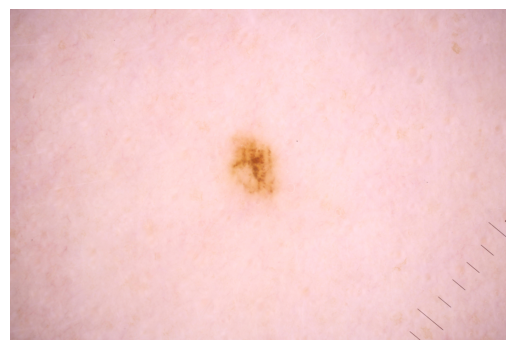

Image: 8


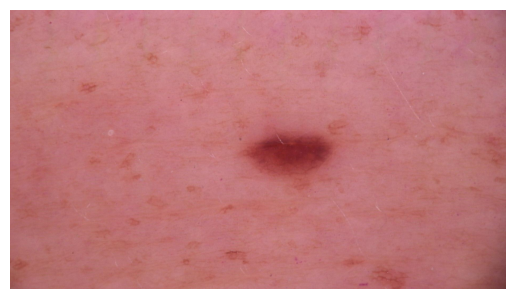

Image: 9


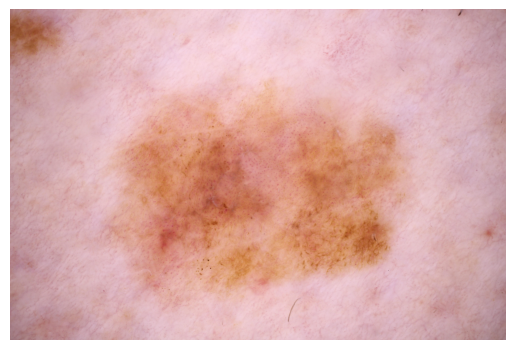

Image: 10


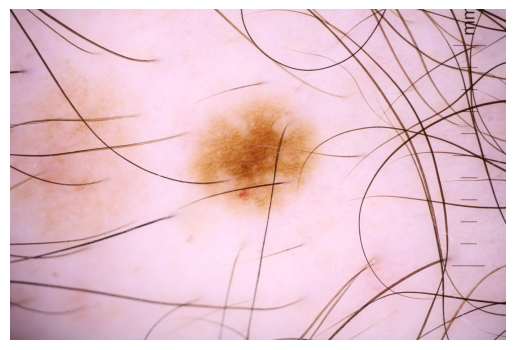

In [8]:
for i in range(10):
    print(f"Image: {i+1}")
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [9]:
# Augment the dataset
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD  = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
def augment(image, image_size, training=True):


    image = tf.image.convert_image_dtype(image, tf.float32)

    if training:

        rand_scale = tf.random.uniform([], 0.8, 1.0)
        orig_h = tf.shape(image)[0]
        orig_w = tf.shape(image)[1]
        crop_h = tf.cast(rand_scale * tf.cast(orig_h, tf.float32), tf.int32)
        crop_w = tf.cast(rand_scale * tf.cast(orig_w, tf.float32), tf.int32)
    
        image = tf.image.random_crop(image, size=[crop_h, crop_w, 3])
        image = tf.image.resize(image, [image_size, image_size])
    
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
    
        k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
    
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.02)
    
        image = tf.clip_by_value(image, 0.0, 1.0)
    
        noise_std = tf.random.uniform([], 0.0, 0.05)  
        noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=noise_std)
        image = image + noise
        image = tf.clip_by_value(image, 0.0, 1.0)

        def apply_cutout(img):
            h = tf.shape(img)[0]
            w = tf.shape(img)[1]
        
      
            cutout_frac = tf.random.uniform([], 0.2, 0.4)
            ch = tf.cast(cutout_frac * tf.cast(h, tf.float32), tf.int32)
            cw = tf.cast(cutout_frac * tf.cast(w, tf.float32), tf.int32)
        
    
            cy = tf.random.uniform([], 0, h - ch + 1, dtype=tf.int32)
            cx = tf.random.uniform([], 0, w - cw + 1, dtype=tf.int32)
        
    
            mask = tf.ones((h, w), dtype=tf.float32)
            mask = tf.tensor_scatter_nd_update(
                mask,
                indices=tf.reshape(
                    tf.stack(tf.meshgrid(tf.range(cy, cy + ch),
                                         tf.range(cx, cx + cw),
                                         indexing="ij"), axis=-1),
                    [-1, 2]
                ),
                updates=tf.zeros([ch * cw], dtype=tf.float32)
            )
        
    
            mask = tf.expand_dims(mask, -1)
            mask = tf.concat([mask, mask, mask], axis=-1)
        
            return img * mask
    
        do_cutout = tf.less(tf.random.uniform([]), 0.5)
        image = tf.cond(do_cutout, lambda: apply_cutout(image), lambda: image)

    else:
        image = tf.image.resize(image, [image_size, image_size])
    
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    
    return image

2025-12-08 20:50:08.512703: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Augmented Image 1:


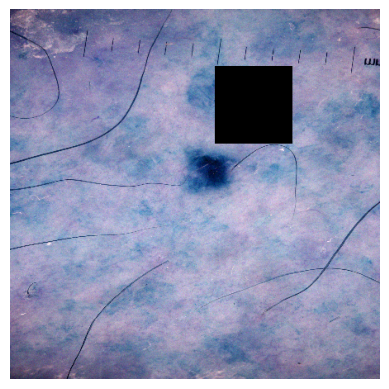

Augmented Image 2:


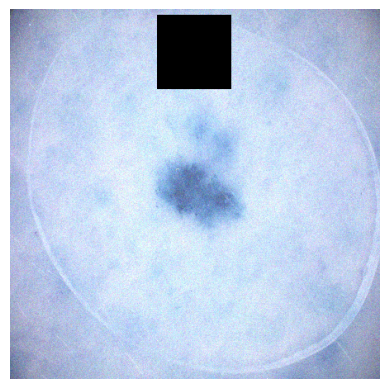

Augmented Image 3:


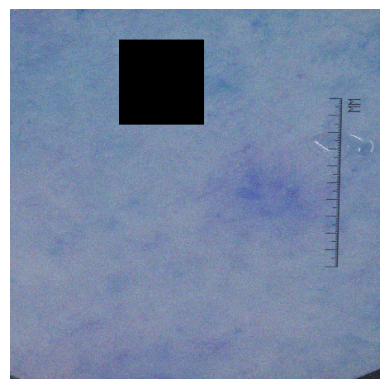

Augmented Image 4:


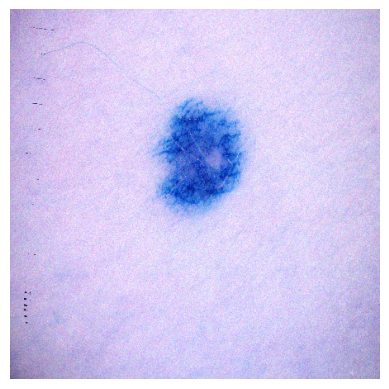

Augmented Image 5:


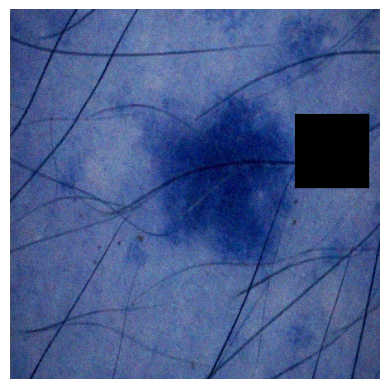

Augmented Image 6:


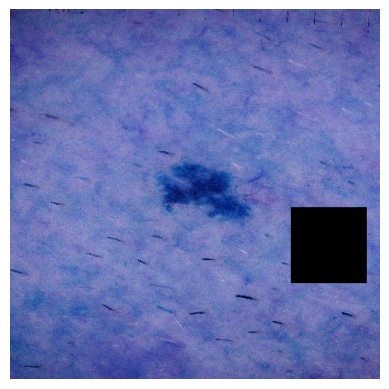

Augmented Image 7:


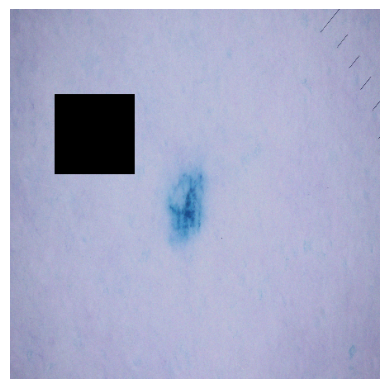

Augmented Image 8:


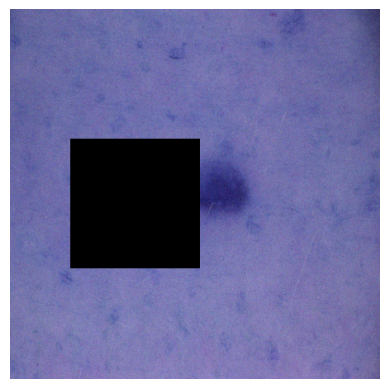

Augmented Image 9:


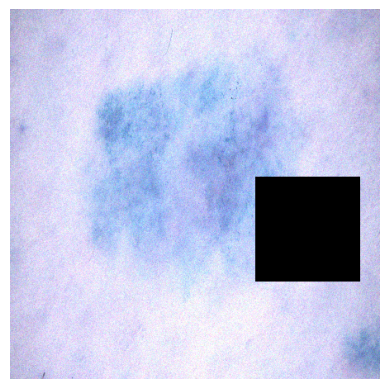

Augmented Image 10:


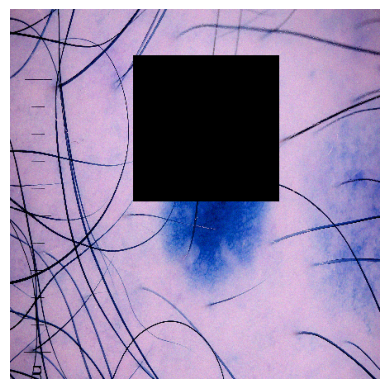

In [10]:
IMAGE_SIZE = 448
for i in range(10):

    img_tf = tf.convert_to_tensor(images[i]) 
    aug_tf = augment(img_tf, IMAGE_SIZE, training=True)  


    aug_np = aug_tf.numpy()
    mean = IMAGENET_MEAN.numpy().reshape(1, 1, 3)
    std = IMAGENET_STD.numpy().reshape(1, 1, 3)
    aug_np = aug_np * std + mean
    aug_np = np.clip(aug_np, 0.0, 1.0)

    print(f"Augmented Image {i+1}:")
    plt.imshow(aug_np)
    plt.axis("off")
    plt.show()
